# Comparison of an SMPI trace with optimization levels 1 and 3

In [1]:
import io
import zipfile
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
import json
import re
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def filter_pajeng(pajeng_output, keep):
    lines = pajeng_output.split(b'\n')
    lines = [l for l in lines if l.startswith(keep.encode())]
    return b'\n'.join(lines)

def _read_paje_state(archive_name, csv_name, has_msg_size=False, replace_func=('MPI', 'MPI')):
    columns=['type', 'rank', 'container', 'start', 'end', 'duration', 'level', 'function']
    if has_msg_size:
        columns.append('tmp')
    df = read_csv(archive_name, csv_name, columns=columns, filter_func=lambda x: filter_pajeng(x, 'State'))
    df['function'] = df['function'].str.replace(*replace_func).str.strip()  # for some reason Simgrid uses PMPI_Wait and not MPI_Wait
    df['msg_size'] = -1
    if has_msg_size:
        df.loc[df['function'].isin(['MPI_Recv', 'MPI_Send', 'MPI_Isend', 'MPI_Irecv']), 'msg_size'] = df['tmp']
        df['msg_size'] = df['msg_size'].astype(int)
    df['rank'] = df['rank'].str.slice(5).astype(int)  # changing 'rank42' into 42
    return df

def read_mpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True)
    return df

def read_smpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True, ('PMPI', 'MPI'))
    df['rank'] = -df['rank']  # in SMPI, we have 'rank-42' and not 'rank42', so there remains a - that we should remove
    return df

def read_smpi_link(archive_name, csv_name):
    df = read_csv(archive_name, csv_name,
                  columns=['type', 'level', 'container', 'start', 'end', 'duration', 'commType', 'src', 'dst', 'msg_size'],
                  filter_func=lambda x: filter_pajeng(x, 'Link'))
    df['src'] = df['src'].str.slice(6).astype(int)  # changing 'rank42' into 42
    df['dst'] = df['dst'].str.slice(6).astype(int)  # changing 'rank42' into 42
#    df['remote'] = (df['src'] // 32) != (df['dst'] // 32)
    return df

def read_archive(archive_name, mode, drop_func=['MPI_Comm_rank', 'MPI_Comm_size', 'MPI_Comm_split', 'MPI_Comm_free', 'MPI_Init', 'MPI_Finalize']):
    assert mode in ('reality', 'simgrid')
    print('# Mode: %s' % mode)
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k']
    blas_trace = read_csv(archive_name, 'trace_blas_0.csv', columns=blas_col)
    print('\tBLAS trace: %6d lines' % len(blas_trace))
    blas_trace['start'] = blas_trace.timestamp
    blas_trace['end'] = blas_trace.timestamp + blas_trace.duration
    blas_trace = blas_trace[['function', 'start', 'end', 'rank', 'm', 'n', 'k']]
    blas_trace['msg_size'] = -1
    blas_trace['kind'] = 'BLAS'
    if mode == 'reality':
        mpi_trace = read_mpi_state(archive_name, 'trace_mpi_0.csv')
    else:
        mpi_trace = read_smpi_state(archive_name, 'trace_mpi_0.csv')
    print('\tMPI  trace: %6d lines' % len(mpi_trace))
    mpi_trace = mpi_trace[['function', 'start', 'end', 'rank', 'msg_size']]
    mpi_trace['kind'] = 'MPI'
    df = pandas.concat([blas_trace, mpi_trace])
    df['mode'] = mode
    df['rank+1'] = df['rank'] + 1
    old_len = len(df)
    df = df[~df['function'].str.strip().isin(drop_func)]
    print('Removed %d events with functions in %s' % (old_len-len(df), ', '.join(drop_func)))
    if mode == 'reality':
        df_links = None
    else:
        df_links = read_smpi_link(archive_name, 'trace_mpi_0.csv')
    df['duration'] = df['end'] - df['start']
    df['function'] = df['function'].str.strip()
    return df, df_links

def get_optimization(filename):
    history = json.loads(zipfile.ZipFile(filename).read('history.json'))
    make_cmd = [cmd for cmd in history if 'SMPI_OPTIMIZATION' in cmd['command']][0]['command']
    opt = re.findall('SMPI_OPTIMIZATION[^\s-]*', make_cmd)[0]
    if opt == 'SMPI_OPTIMIZATION':
        return 4
    else:
        assert opt[-2] == '='
        return int(opt[-1])

simgrid_file = '../smpi_hpl/grenoble_2019-01-24_1843072.zip'
reality_file = 'grenoble_2019-01-24_1843055.zip'

simgrid_trace, smpi_link = read_archive(simgrid_file, 'simgrid')
reality_trace, _ = read_archive(reality_file, 'reality')

traces = pandas.concat([simgrid_trace, reality_trace])

traces.head()

# Mode: simgrid
	BLAS trace: 535526 lines
	MPI  trace: 1691785 lines
Removed 1024 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode: reality
	BLAS trace: 3182127 lines
	MPI  trace: 265296 lines
Removed 31616 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize


,end,function,k,kind,m,msg_size,n,rank,start,mode,rank+1,duration
0,0.026373,idamax,NaN,BLAS,3200.0,-1,NaN,0,0.026339,simgrid,1,0.000034
1,0.026416,dcopy,NaN,BLAS,128.0,-1,NaN,0,0.026407,simgrid,1,0.000009
2,0.026433,dcopy,NaN,BLAS,128.0,-1,NaN,0,0.026425,simgrid,1,0.000008
3,0.026458,dcopy,NaN,BLAS,132.0,-1,NaN,0,0.026451,simgrid,1,0.000006
4,0.026500,dscal,NaN,BLAS,3199.0,-1,NaN,0,0.026487,simgrid,1,0.000013


In [2]:
smpi_link.head()

,type,level,container,start,end,duration,commType,src,dst,msg_size
0,Link,0,MPI_LINK,0.000007,0.000008,0.000001,PTP,511,510,4
1,Link,0,MPI_LINK,0.000007,0.000009,0.000002,PTP,499,498,4
2,Link,0,MPI_LINK,0.000007,0.000009,0.000002,PTP,505,504,4
3,Link,0,MPI_LINK,0.000007,0.000009,0.000002,PTP,487,486,4
4,Link,0,MPI_LINK,0.000007,0.000009,0.000002,PTP,507,506,4


## HPL result

In [3]:
res = read_csv(reality_file, 'results.csv')
print('%s seconds' % res['time'].max())
res

0.41 seconds


,pfact,matrix_size,mem_align,depth,swap,proc_p,residual,gflops,rfact,proc_q,time,bcast,thread_per_process,block_size,process_per_node
0,1,50000,8,1,0,16,NaN,203200.0,2,32,0.41,2,1,128,32


In [4]:
res = read_csv(simgrid_file, 'results.csv')
print('%s seconds' % res['time'].max())
res

1.13 seconds


,process_per_node,rfact,minor_page_fault,dtrsm_intercept,gflops,cpu_utilization,mem_align,usr_time,block_size,matrix_size,...,depth,bcast,sys_time,major_page_fault,dgemm_coefficient,proc_q,dtrsm_coefficient,application_time,thread_per_process,proc_p
0,32,2,1124163,6.929164e-07,73550.0,1.03,8,54.73,128,50000,...,1,2,9.88,0,6.484604e-11,32,8.021068e-11,15.7046,1,16


## Checking the parameters

In [5]:
read_csv(simgrid_file, 'exp_smpi.csv')

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept
0,50000,128,16,32,1,2,2,1,0,8,32,1,6.484604e-11,0.000001,8.021068e-11,6.929164e-07


In [6]:
read_csv(reality_file, 'exp.csv')

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process
0,50000,128,16,32,1,2,2,1,0,8,32,1


In [7]:
print(zipfile.ZipFile(simgrid_file).read('dahu.xml').decode('ascii'))

<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.9654918472829634e-07:9.636195922971908e-11;8133:0.0:0.0;15831:0.0:0.0;33956:0.0:0.0;63305:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375224e-06:8.456019002037343e-11;8133:0.0:0.0;15831:0.0:0.0;33956:0.0:0.0;63305:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.93122952108322e-07:7.051204536228499e-11;8133:3.601990790153314e-07:1.2449128895712003e-10;15831:2.977016881030904e-06:4.130261264964205e-11;33956:3.1334661540668004e-06:3.293458765282178e-11;63305:6.939993663604218e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4709912642540426;8133:0.6770561715947873;15831:0.7091971477925826;33956:0.7033449540683548;63305:0.9867951082730284"/>
        <prop id="smpi/lat-factor" value="0:1.1347371681807956;8133:29.84698135078078;15831:30.274775156187765;33956:64.63917831305292;633

## Removing the initialization and the finalization in the traces?

In [8]:
tmp = traces[traces['function'].isin(['dgemm', 'dtrsm'])].copy().reset_index(drop=True)
tmp['size_product'] = -1
tmp.loc[tmp['function'] == 'dgemm', 'size_product'] = tmp['m'] * tmp['n'] * tmp['k']
tmp.loc[tmp['function'] == 'dtrsm', 'size_product'] = tmp['m'] * tmp['n']**2

In [9]:
tmp.groupby(['function', 'mode']).sum()[['size_product', 'duration']]

size_product    duration
function mode                             
dgemm    reality  1.577972e+12  115.641200
         simgrid  1.577972e+12  106.658940
dtrsm    reality  6.506754e+10    4.740542
         simgrid  6.506754e+10    4.915074

In [10]:
def split(df):
    return [df[(df['rank'] == rank) & (df['mode'] == mode)] for rank in df['rank'].unique() for mode in df['mode'].unique()]

def crop(df, func_name):
    func_calls = df[df['function'] == func_name]
    assert len(func_calls) == 2
    start = func_calls['end'].min()
    end = func_calls['start'].max()
    df = df[(df['start'] > start) & (df['end'] < end)].copy()
    min_time = df['start'].min()
    df['start'] -= min_time
    df['end'] -= min_time
    return df

def crop_all(df, func_name):
    df_ranks = [crop(tmp_df, func_name) for tmp_df in split(df)]
    df = pandas.concat(df_ranks)
    return df

In [11]:
tmp = crop_all(traces, 'MPI_Bcast')
tmp = tmp[tmp['function'].isin(['dgemm', 'dtrsm'])].copy().reset_index(drop=True)
tmp['size_product'] = -1
tmp.loc[tmp['function'] == 'dgemm', 'size_product'] = tmp['m'] * tmp['n'] * tmp['k']
tmp.loc[tmp['function'] == 'dtrsm', 'size_product'] = tmp['m'] * tmp['n']**2
tmp.groupby(['function', 'mode']).sum()[['size_product', 'duration']]

size_product    duration
function mode                             
dgemm    reality  9.196078e+11   67.046028
         simgrid  1.577959e+12  106.656683
dtrsm    reality  3.794362e+10    2.689358
         simgrid  6.506747e+10    4.913596

We see here that we removed a lot of calls to dgemm by doing so... Let's not do it.

## Visualizing the trace

In [12]:
def plot(df, wrap=['mode', 'kind']):
    gc = ggplot(df) + geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='function')) + facet_wrap(wrap) + theme_bw()
    return gc

def plot_bounded(df, start, end, ranks, wrap=['mode', 'kind']):
    df = df[df['rank'].isin(ranks)]
    df = df[(df['end'] >= start) & (df['start'] <= end)].copy()
    df.loc[df['start'] < start, 'start'] = start
    df.loc[df['end'] > end, 'end'] = end
    return plot(df, wrap) + xlim(start, end) + ggtitle('Events between %.1fs and %.1fs for ranks in %s' % (start, end, ranks))

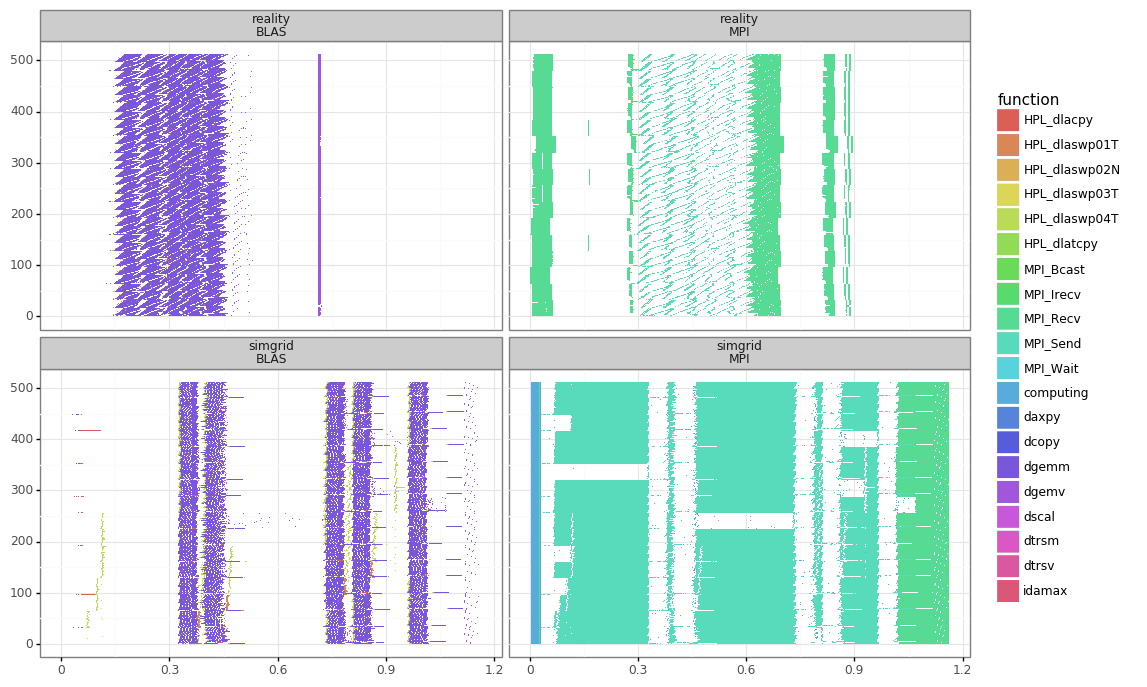

<ggplot: (-9223363306069203077)>

In [13]:
plot(traces)

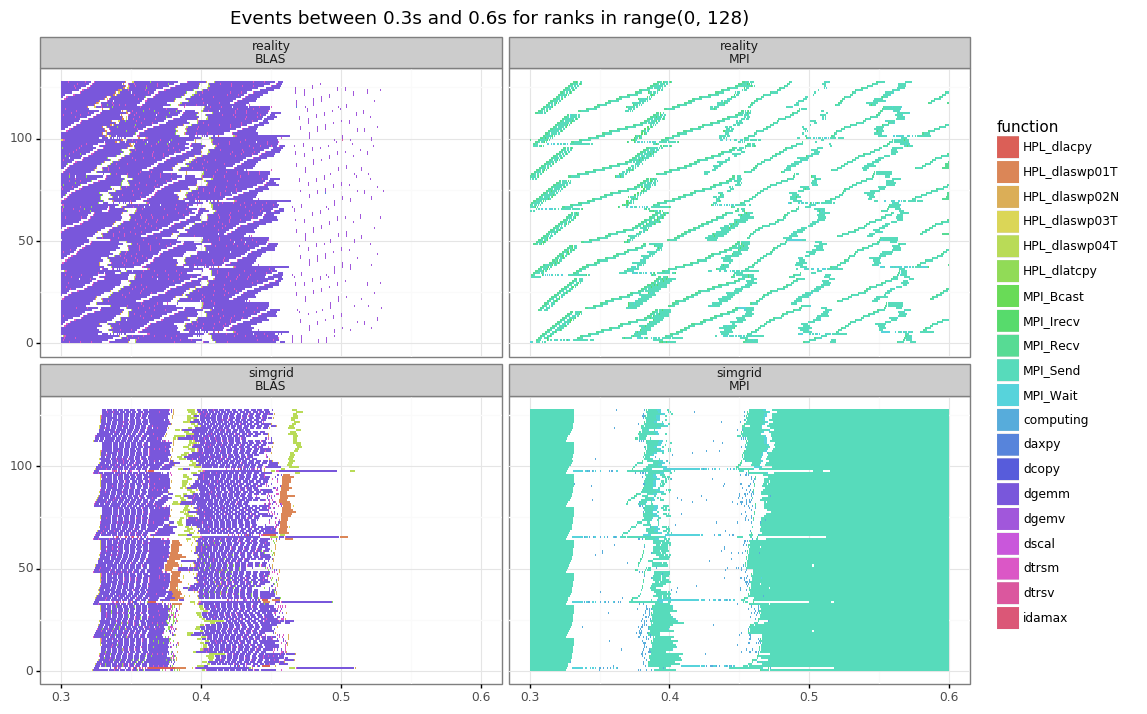

<ggplot: (8730785840988)>

In [14]:
plot_bounded(traces, 0.3, 0.6, range(0, 128))

## Plotting the total time spent in each function

In [15]:
def plot_total_duration(df, function):
    df = df[df.function == function][['rank', 'mode', 'start', 'end', 'duration']].copy()
    df = df.groupby(['rank', 'mode']).sum().reset_index()
    plot = ggplot(df, aes(x='rank', y='duration', color='factor(mode)')) + geom_point() + theme_bw() + expand_limits(y=0) + ggtitle('Total time spent in function %s' % function)
    print(plot)
    return  # not plotting the differencep plot
    modes = list(df['mode'].unique())
    if len(modes) != 2:
        return
    df1 = df[df['mode'] == modes[0]]
    df2 = df[df['mode'] == modes[1]]
    df = df1.set_index('rank').join(df2.set_index('rank'), rsuffix='_simgrid').reset_index()
    df['difference'] = (df['duration_simgrid'] - df['duration'])/df['duration'] * 100
    max_point = df[df.difference.abs() == df.difference.abs().max()]
    max_rank = list(max_point['rank'])[0]
    max_diff = list(max_point['difference'])[0]
    plot = ggplot(df, aes(x='rank', y='difference')) + geom_point() + theme_bw() + ggtitle('Difference in the total time spent in function %s' % function)
    plot = plot + ylab('duration difference (%)') + geom_hline(yintercept=0, color='red')
    ranks = list(df['rank'])
    mid_rank = (max(ranks) + min(ranks)) / 2
    shift = -1 if max_rank > mid_rank else +1
    plot = plot + annotate('text', label='rank %d, error of %.2f%%' % (max_rank, max_diff), x=max_rank+shift*2, y=max_diff*1.05) + annotate('segment', x=max_rank+shift, y=max_diff*1.05, xend=max_rank, yend=max_diff, size=0.5)
    print(plot)

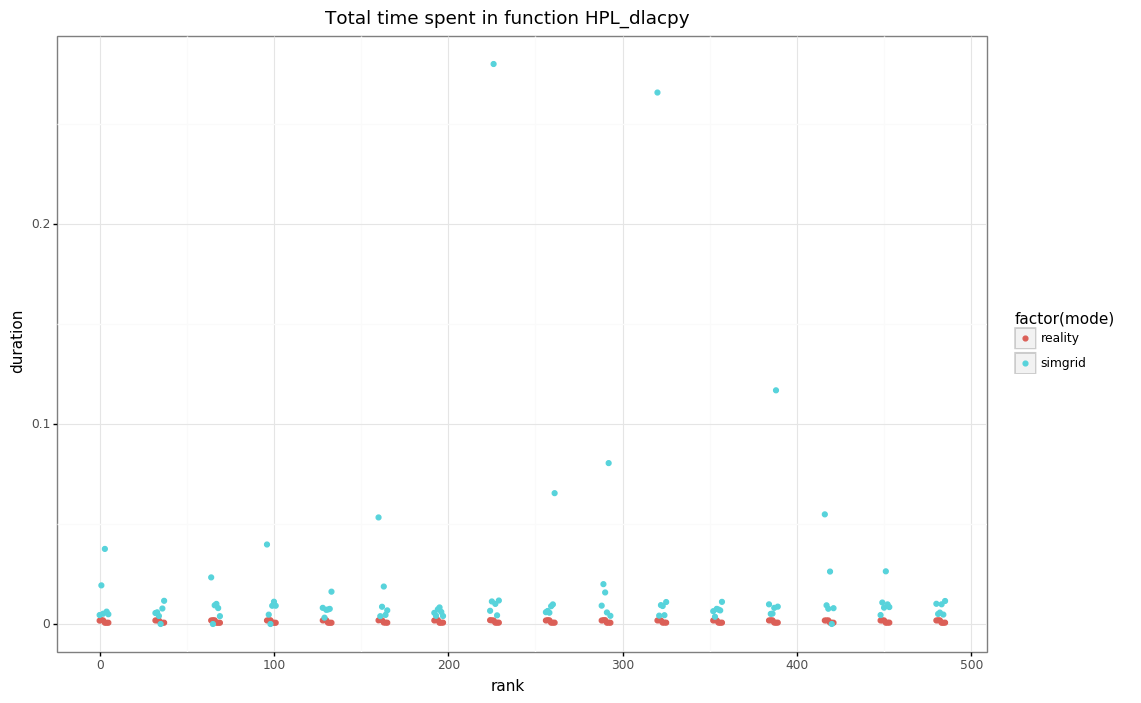

<ggplot: (8730783459904)>


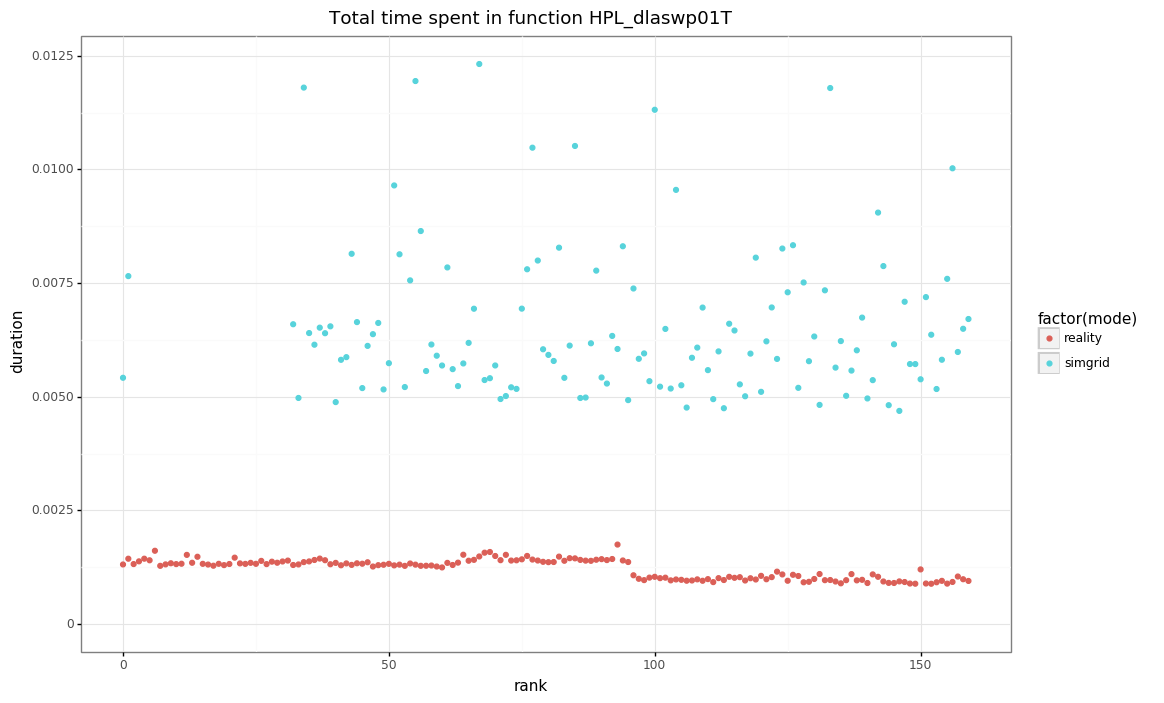

<ggplot: (-9223363306261434813)>


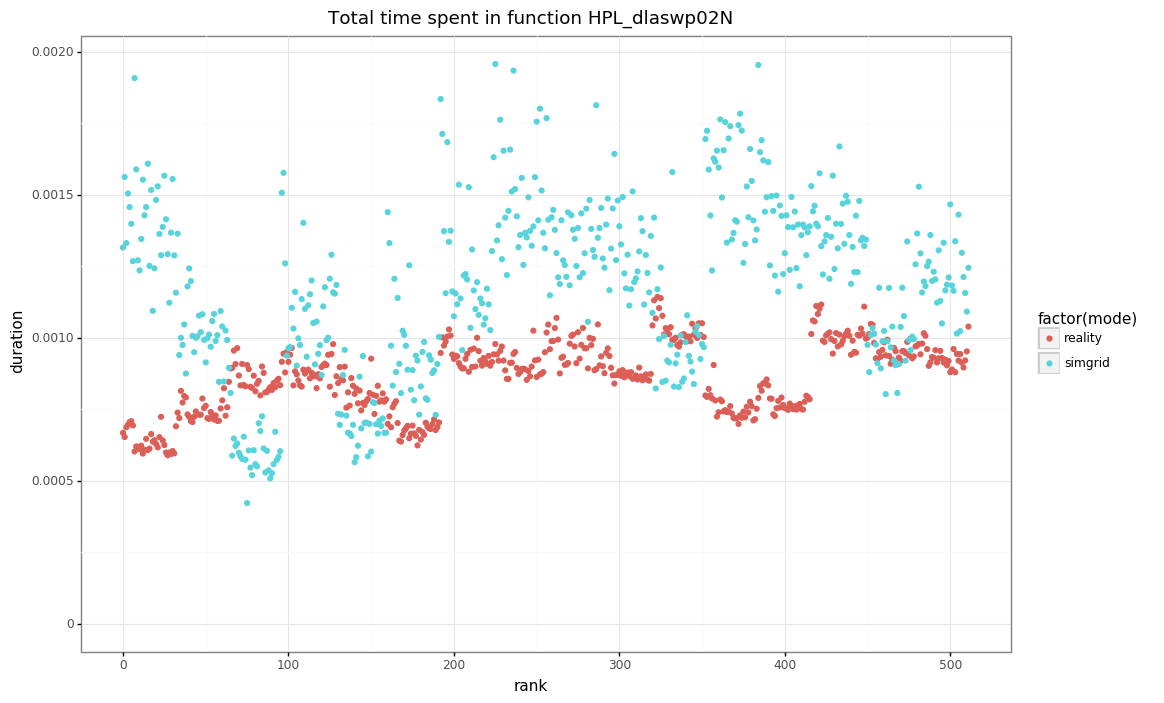

<ggplot: (-9223363306080197302)>


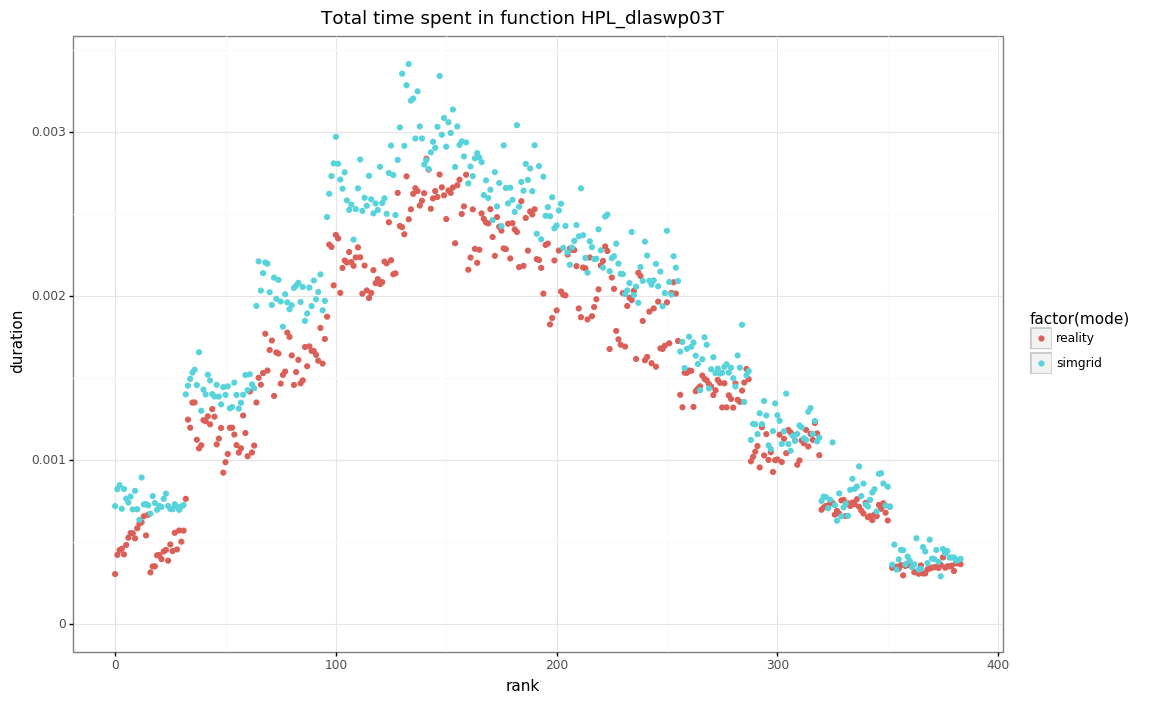

<ggplot: (-9223363306262494285)>


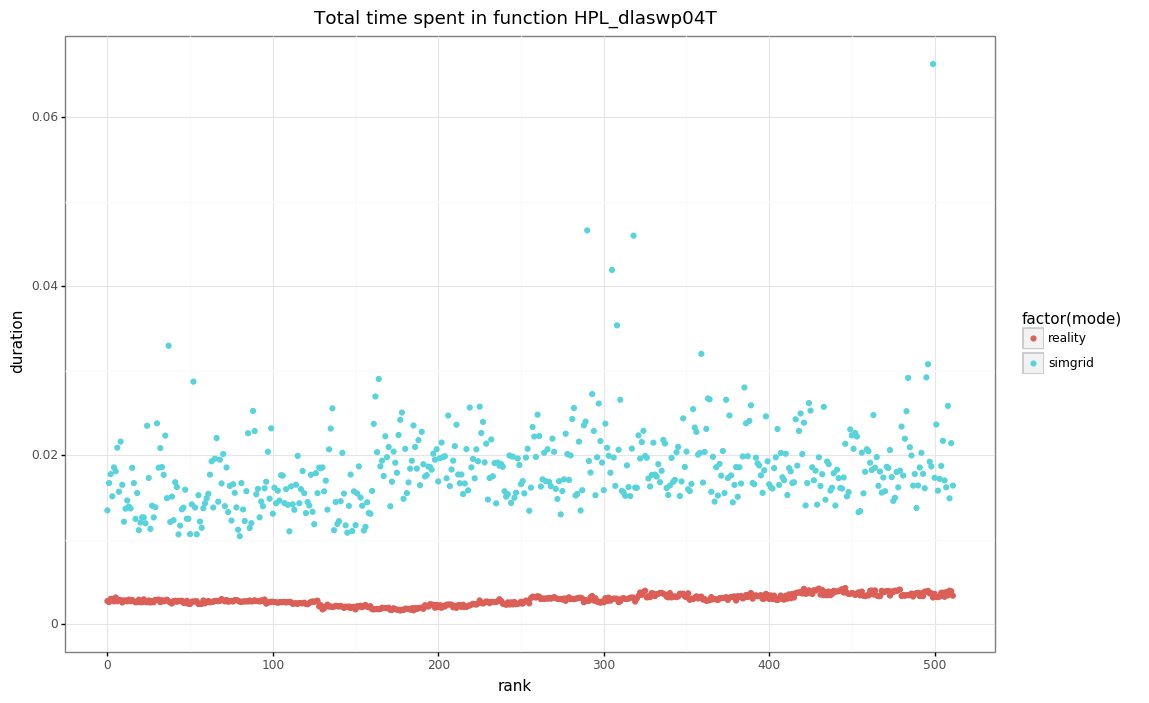

<ggplot: (-9223363306261436563)>


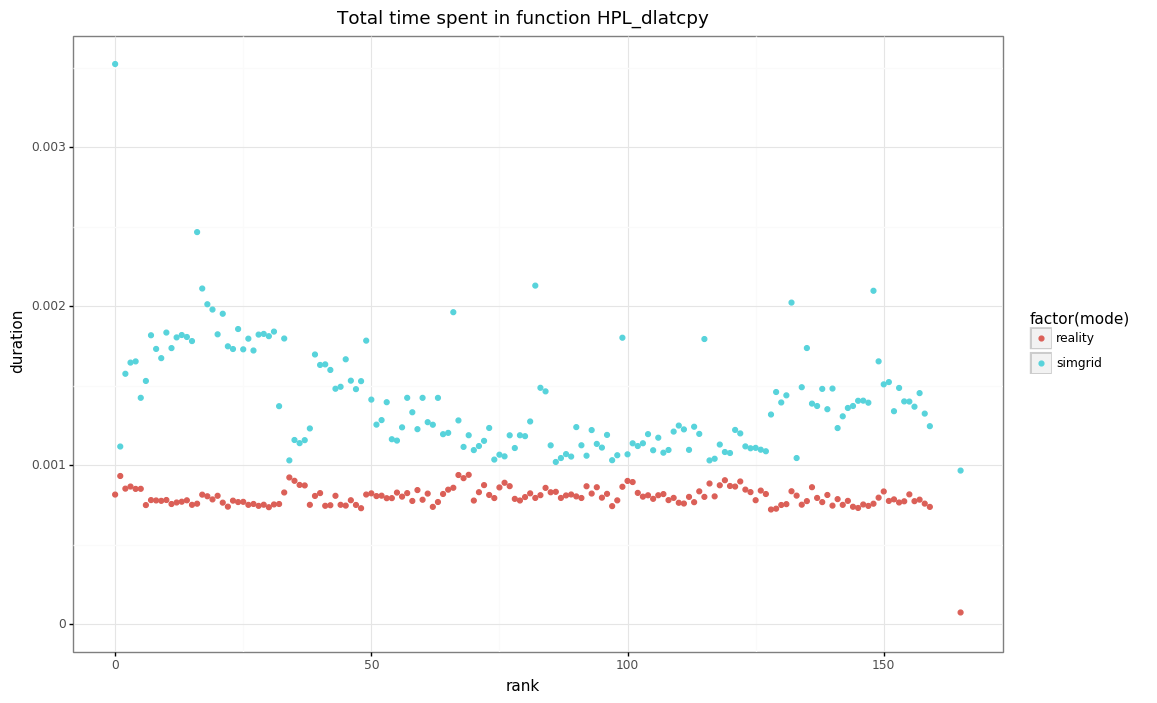

<ggplot: (-9223363306071330055)>


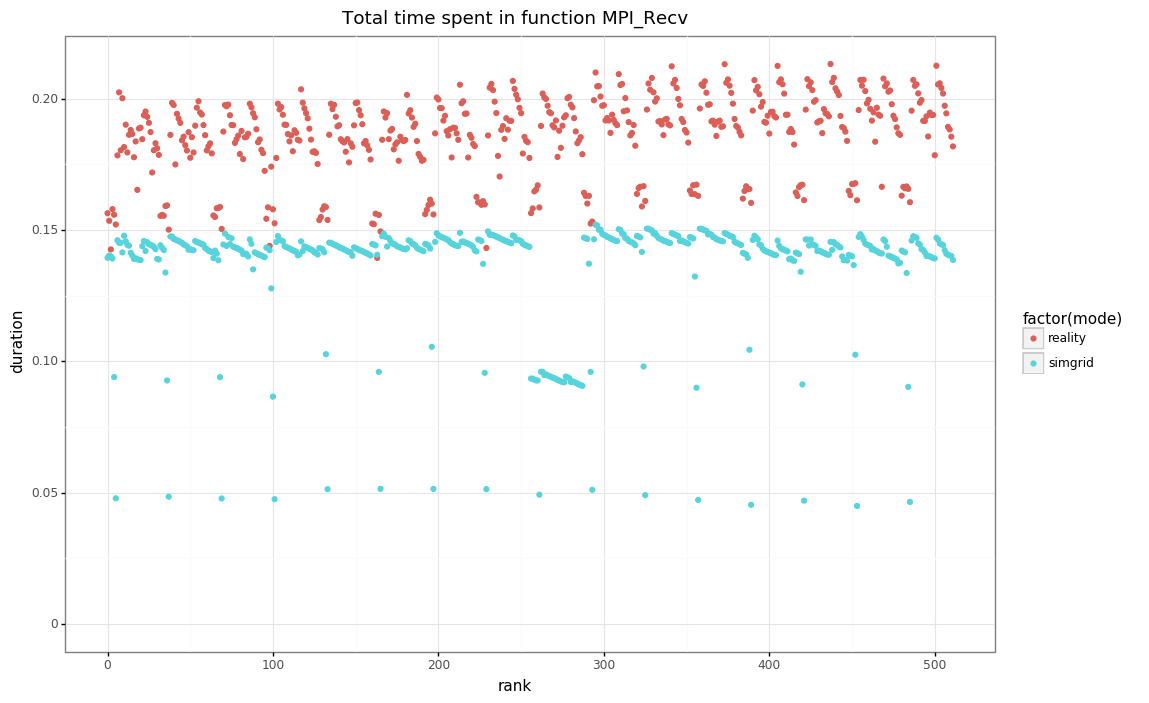

<ggplot: (-9223363306071340600)>


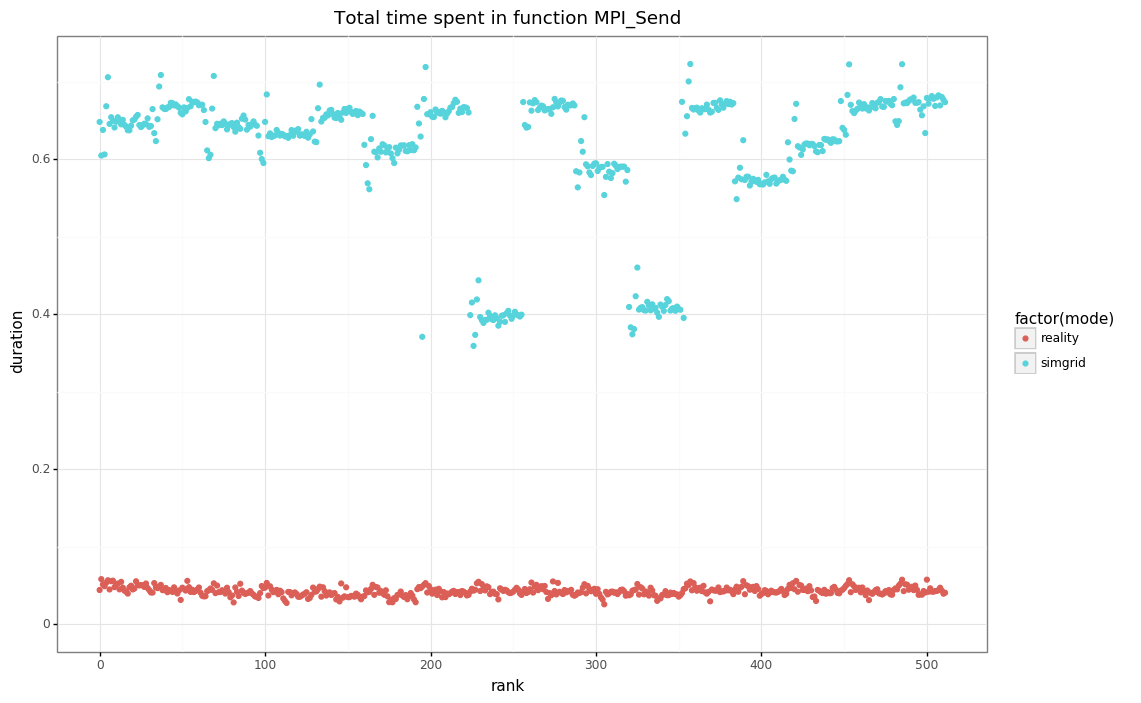

<ggplot: (8730783225664)>


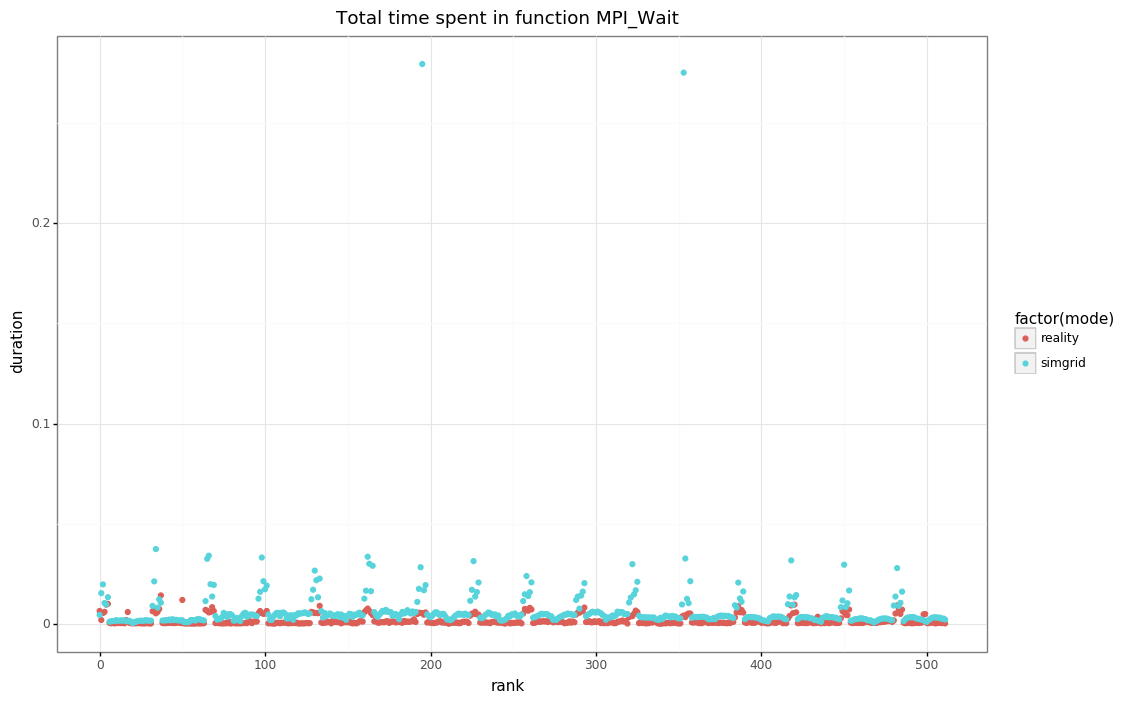

<ggplot: (8730783361593)>


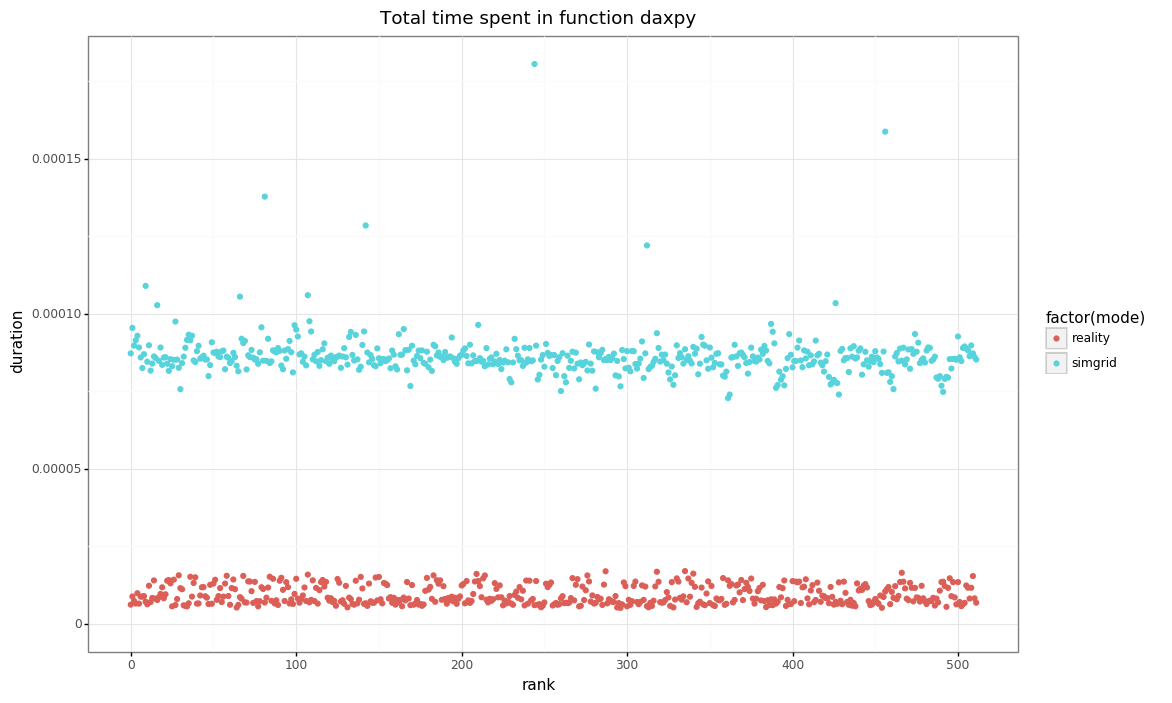

<ggplot: (8730783313458)>


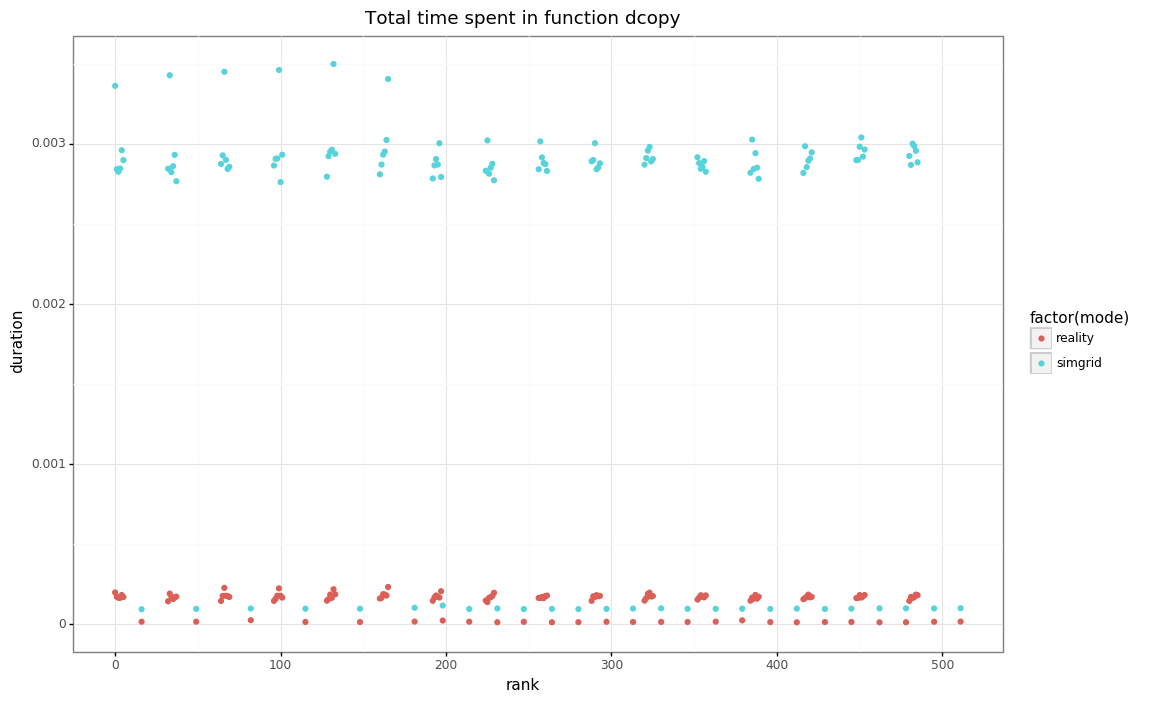

<ggplot: (-9223363306071399357)>


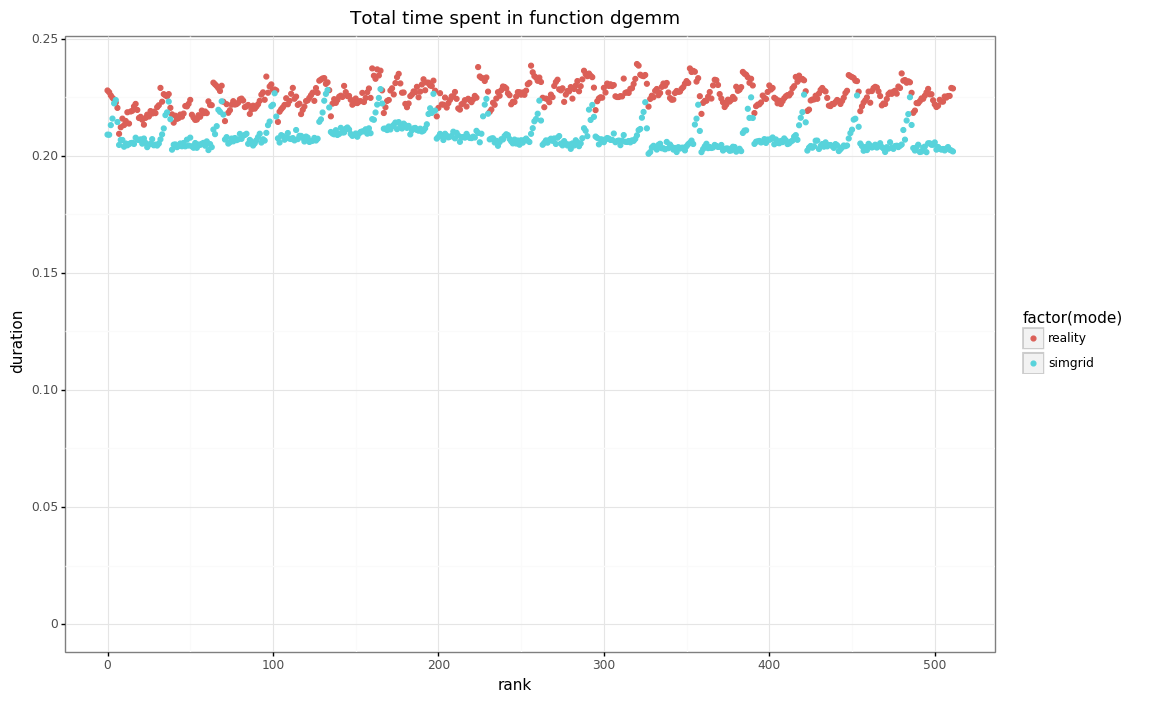

<ggplot: (8730783190315)>


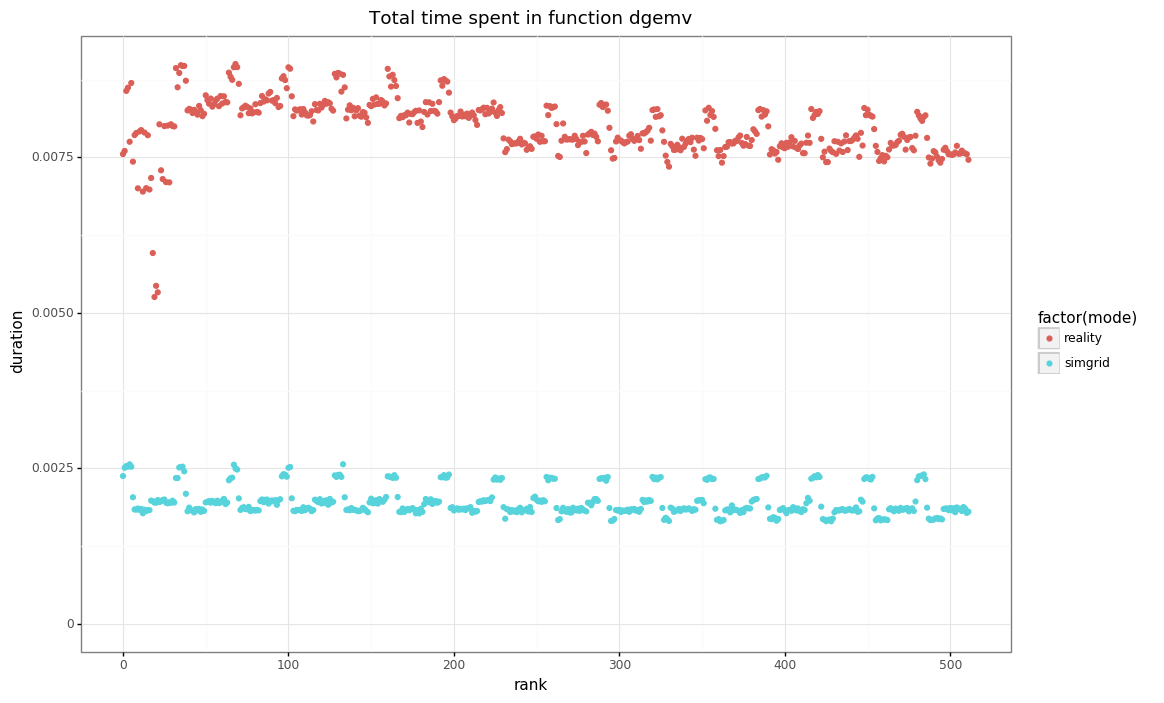

<ggplot: (-9223363306071623420)>


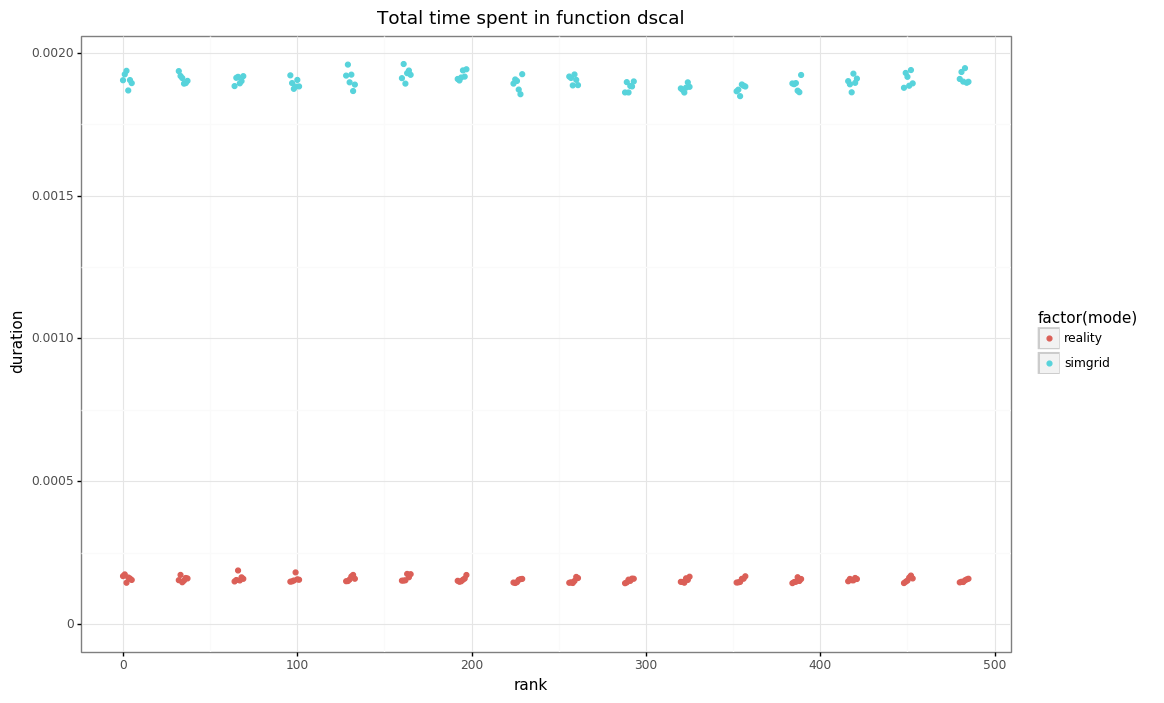

<ggplot: (8730783207109)>


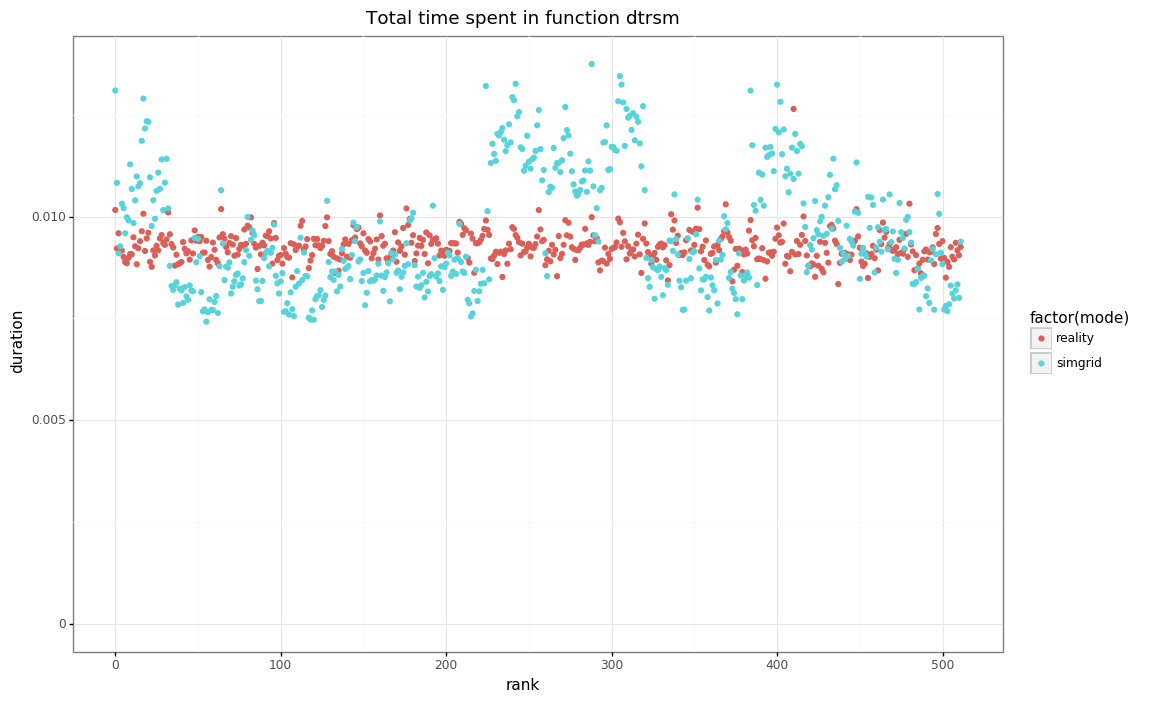

<ggplot: (-9223363306071657468)>


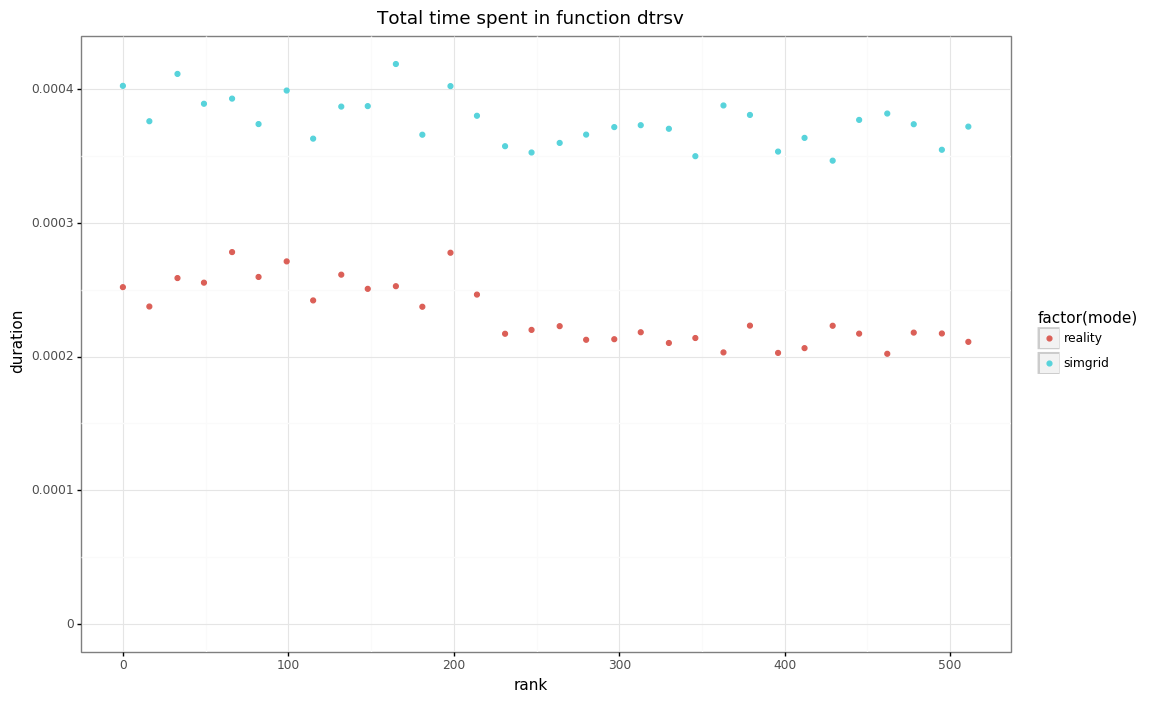

<ggplot: (-9223363306071798745)>


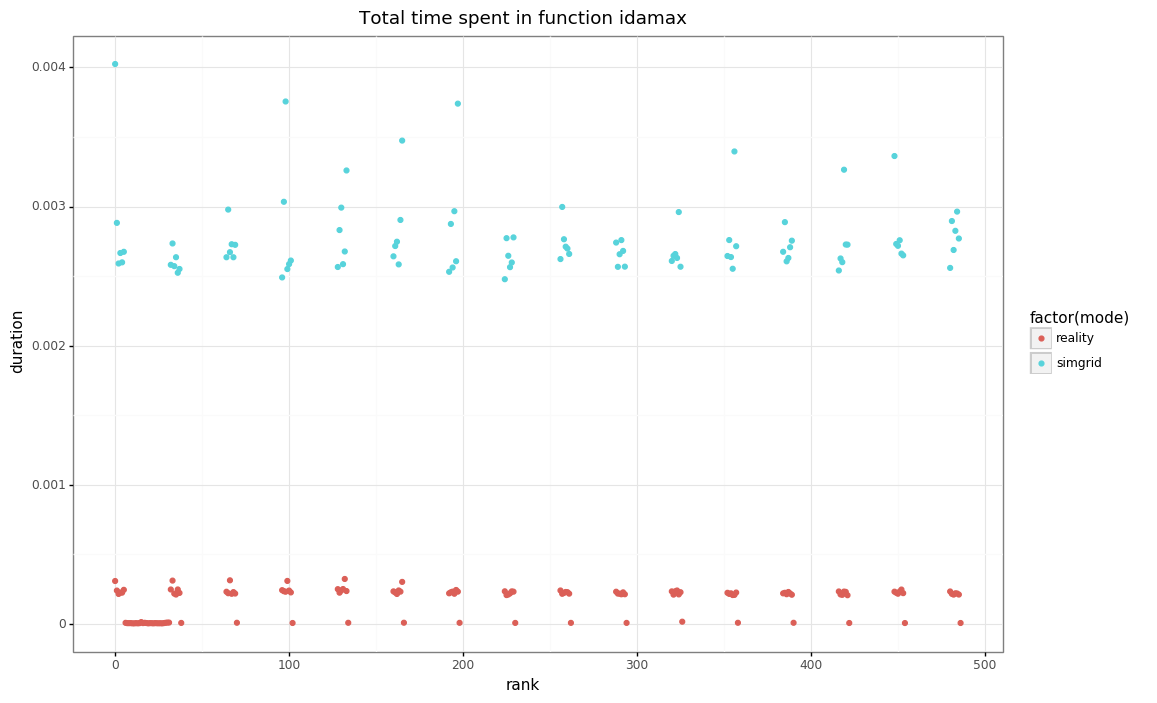

<ggplot: (-9223363306071718859)>


In [16]:
for func in sorted(set(traces[traces['mode'] == 'simgrid'].function.unique()) & set(traces[traces['mode'] == 'reality'].function.unique()) - {'MPI_Bcast', 'MPI_Irecv'}):
    plot_total_duration(traces, func)

## Counting the number of events

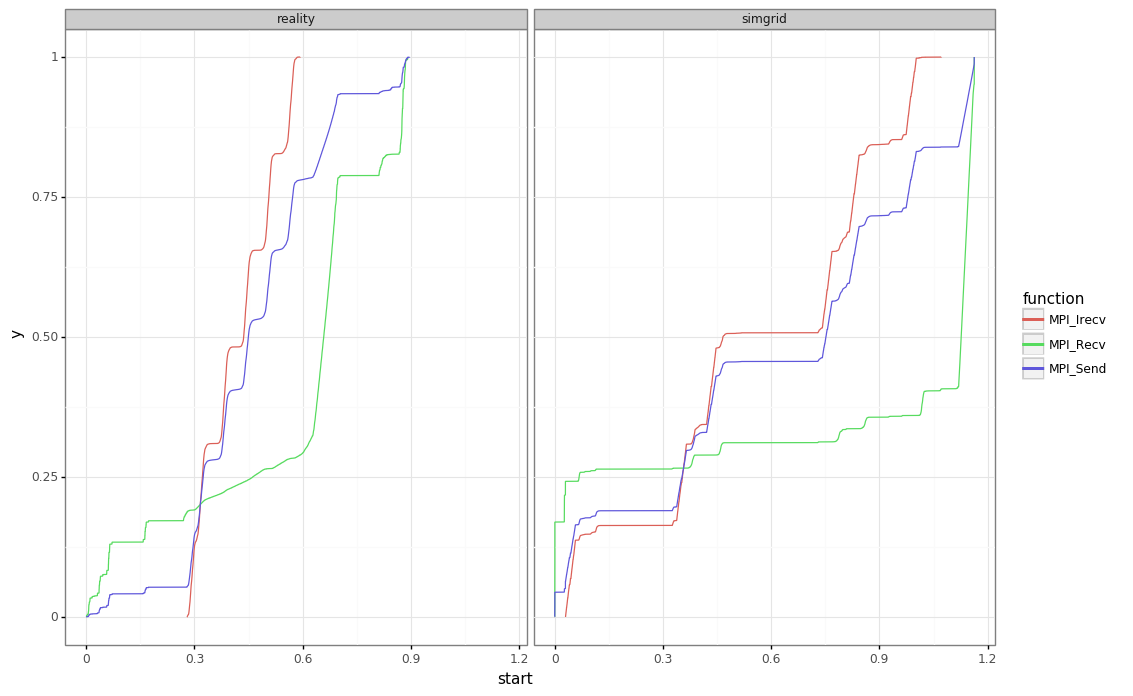

<ggplot: (8730782938197)>

In [17]:
ggplot(traces[traces.function.isin(['MPI_Recv', 'MPI_Send', 'MPI_Irecv'])], aes(x='start', color='function')) + stat_ecdf() + facet_wrap('mode') + theme_bw()

## Comparing the communications

In [18]:
traces[traces['function'].isin(['MPI_Send', 'MPI_Recv', 'MPI_Irecv'])].groupby(['function', 'mode']).sum()[['msg_size', 'duration']]

msg_size    duration
function  mode                            
MPI_Irecv reality   6302121360    0.626334
          simgrid   6455997504    0.000000
MPI_Recv  reality   9898235364   95.163049
          simgrid   9849009612   69.905253
MPI_Send  reality  16200356724   21.745748
          simgrid  16305007116  312.640751

In [19]:
def compute_cumsum(df, column, functions):
    dataframes = []
    for mode in df['mode'].unique():
        for function in functions:
            cols = ['start', 'end', 'function', 'mode'] + [column]
            tmp = df[(df['mode'] == mode) & (df['function'] == function)][cols].copy()
            tmp = tmp.sort_values(by=['start'])
            tmp['cumsum'] = tmp[column].cumsum()
            dataframes.append(tmp)
    return pandas.concat(dataframes)

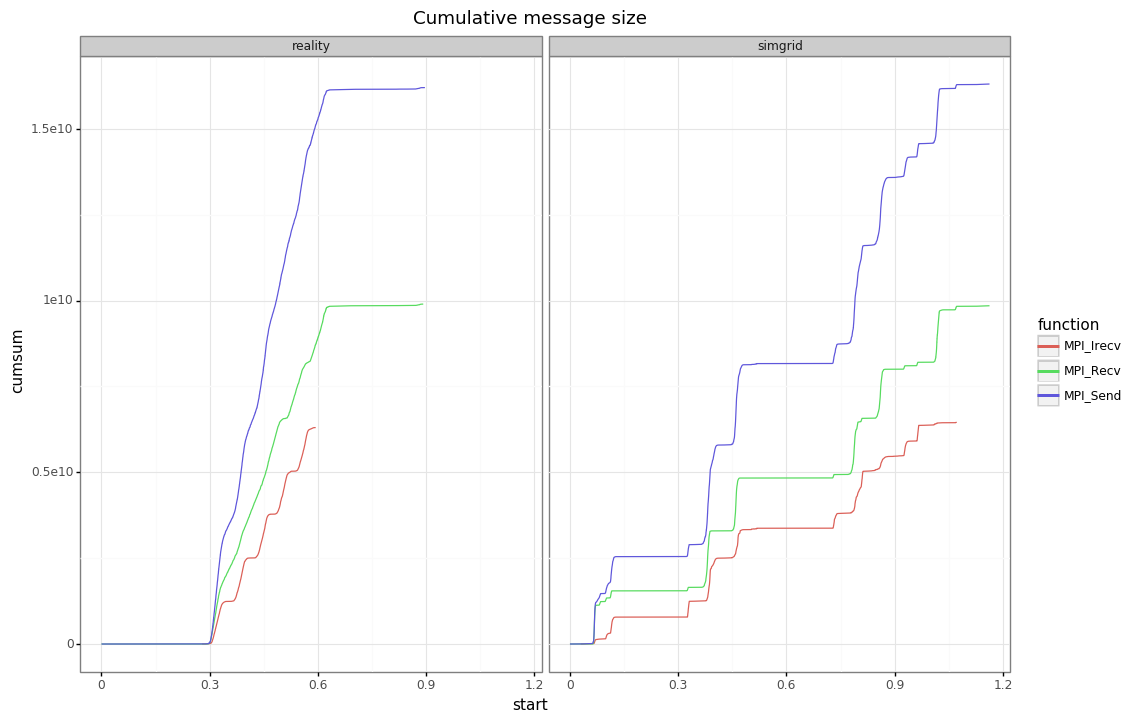

<ggplot: (-9223363306072811509)>

In [20]:
plot = ggplot(compute_cumsum(traces, 'msg_size', ['MPI_Send', 'MPI_Recv', 'MPI_Irecv']), aes(x='start', y='cumsum', color='function', group='function'))
plot + geom_line() + theme_bw() + facet_wrap('mode') + ggtitle('Cumulative message size')

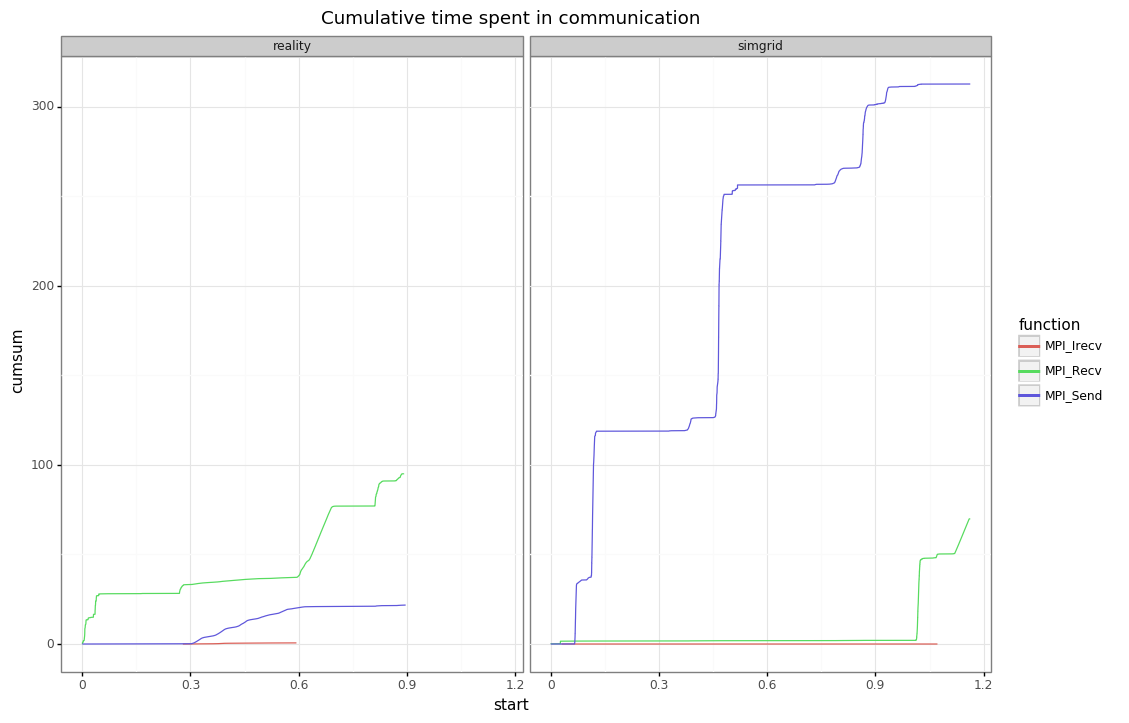

<ggplot: (8730773836622)>

In [21]:
plot = ggplot(compute_cumsum(traces, 'duration', ['MPI_Send', 'MPI_Recv', 'MPI_Irecv']), aes(x='start', y='cumsum', color='function', group='function'))
plot + geom_line() + theme_bw() + facet_wrap('mode') + ggtitle('Cumulative time spent in communication')

## Comparing the computations

In [22]:
tmp = traces[traces['function'].isin(['dgemm', 'dtrsm'])].copy().reset_index(drop=True)
tmp['size_product'] = -1
tmp.loc[tmp['function'] == 'dgemm', 'size_product'] = tmp['m'] * tmp['n'] * tmp['k']
tmp.loc[tmp['function'] == 'dtrsm', 'size_product'] = tmp['m'] * tmp['n']**2

In [23]:
tmp.groupby(['function', 'mode']).sum()[['size_product', 'duration']]

size_product    duration
function mode                             
dgemm    reality  1.577972e+12  115.641200
         simgrid  1.577972e+12  106.658940
dtrsm    reality  6.506754e+10    4.740542
         simgrid  6.506754e+10    4.915074

In [24]:
print(len(tmp))
tmp = tmp[tmp['size_product'] > 0]
print(len(tmp))

3503854
128100


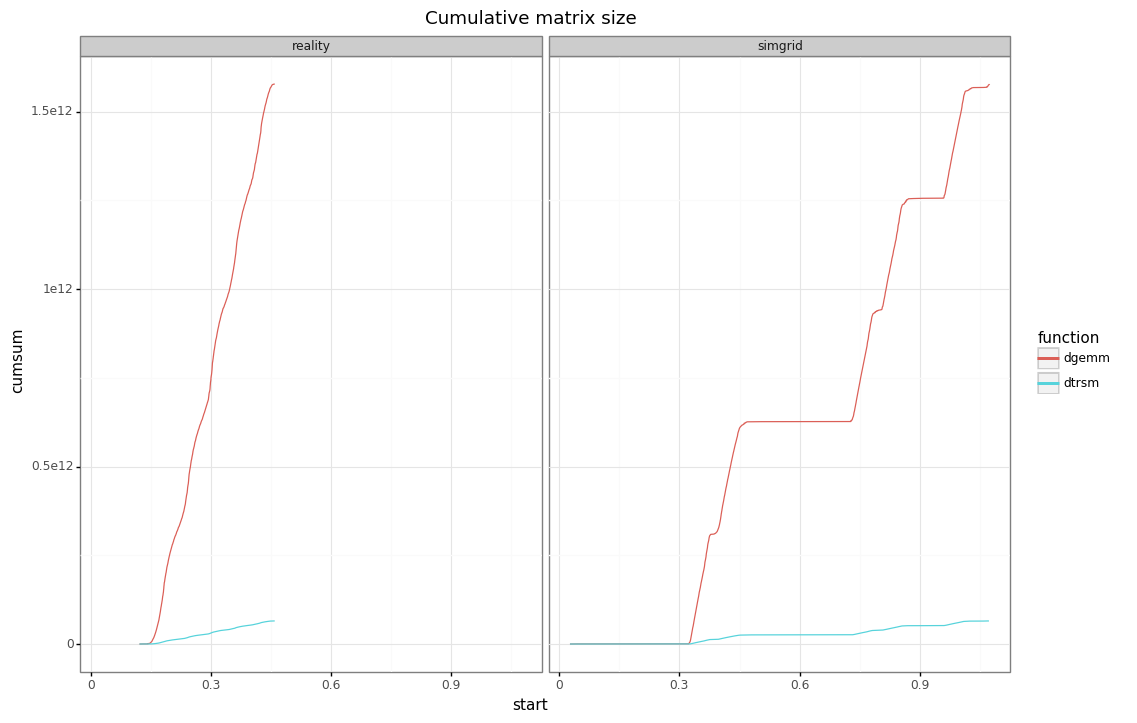

<ggplot: (8730781704968)>

In [25]:
plot = ggplot(compute_cumsum(tmp, 'size_product', ['dgemm', 'dtrsm']), aes(x='start', y='cumsum', color='function', group='function'))
plot + geom_line() + theme_bw() + facet_wrap('mode') + ggtitle('Cumulative matrix size')

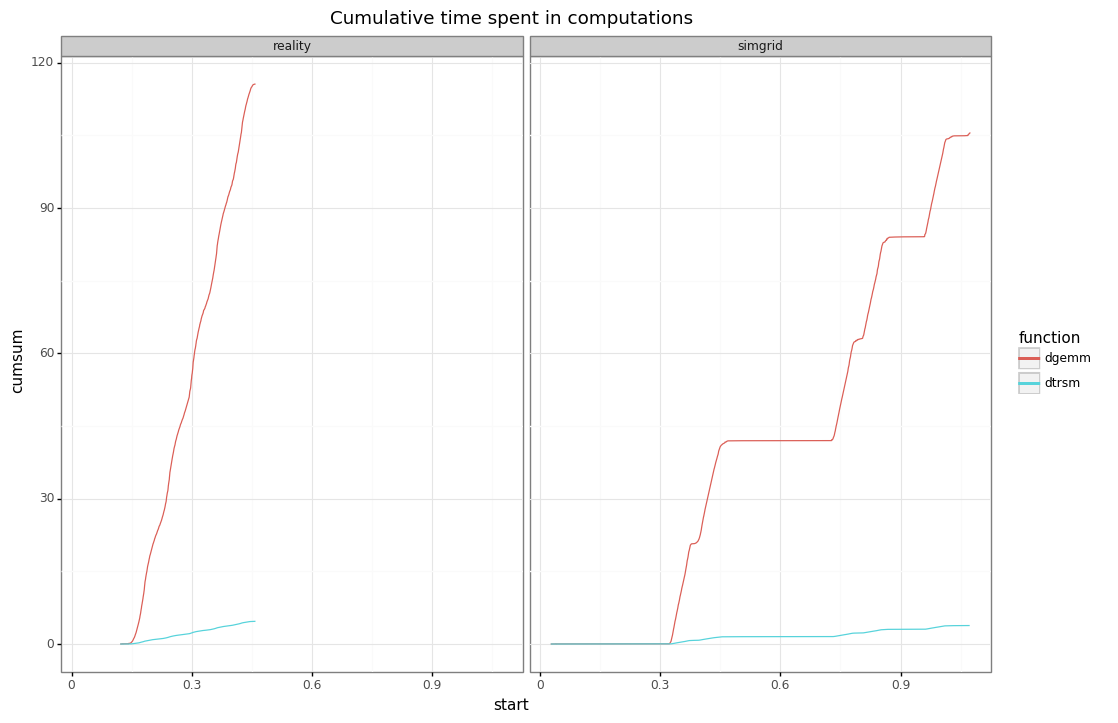

<ggplot: (8730781861668)>

In [26]:
plot = ggplot(compute_cumsum(tmp, 'duration', ['dgemm', 'dtrsm']), aes(x='start', y='cumsum', color='function', group='function'))
plot + geom_line() + theme_bw() + facet_wrap('mode') + ggtitle('Cumulative time spent in computations')

## Plotting the durations

In [27]:
blas = traces[traces['kind'] == 'BLAS'].copy().reset_index()
blas['size_product'] = -1
blas.loc[blas.function == 'dgemm', 'size_product'] = blas.m * blas.n * blas.k
blas.loc[blas.function == 'dtrsm', 'size_product'] = blas.m * blas.n**2
blas.loc[blas.function == 'dtrsv', 'size_product'] = blas.m**2
for func in ['dgemv']:
    blas.loc[blas.function == func, 'size_product'] = blas.m * blas.n
for func in ['daxpy', 'dcopy', 'dscal', 'idamax']:
    blas.loc[blas.function == func, 'size_product'] = blas.m

blas.loc[blas.function.str.startswith('HPL_'), 'size_product'] = blas.m * blas.n
for func in ['HPL_dlaswp04N', 'HPL_dlaswp04T']:
    blas.loc[blas.function == func, 'size_product'] = blas.n * blas.k
blas = blas[blas.size_product > 0].copy()

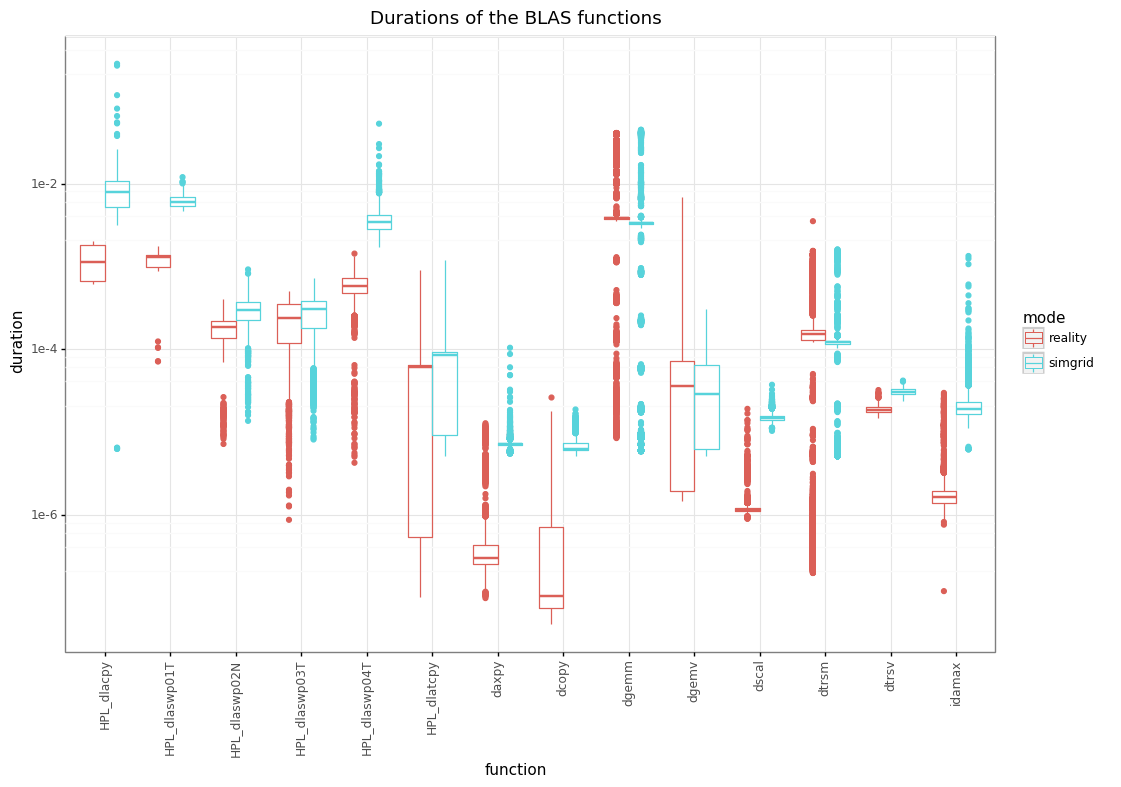

<ggplot: (-9223363306071940657)>

In [28]:
plot = ggplot(blas, aes(x='function', y='duration', color='mode')) + scale_y_log10()
plot = plot + theme_bw() + ggtitle('Durations of the BLAS functions') + geom_boxplot(alpha=0)
plot + theme(axis_text_x=element_text(rotation=90))

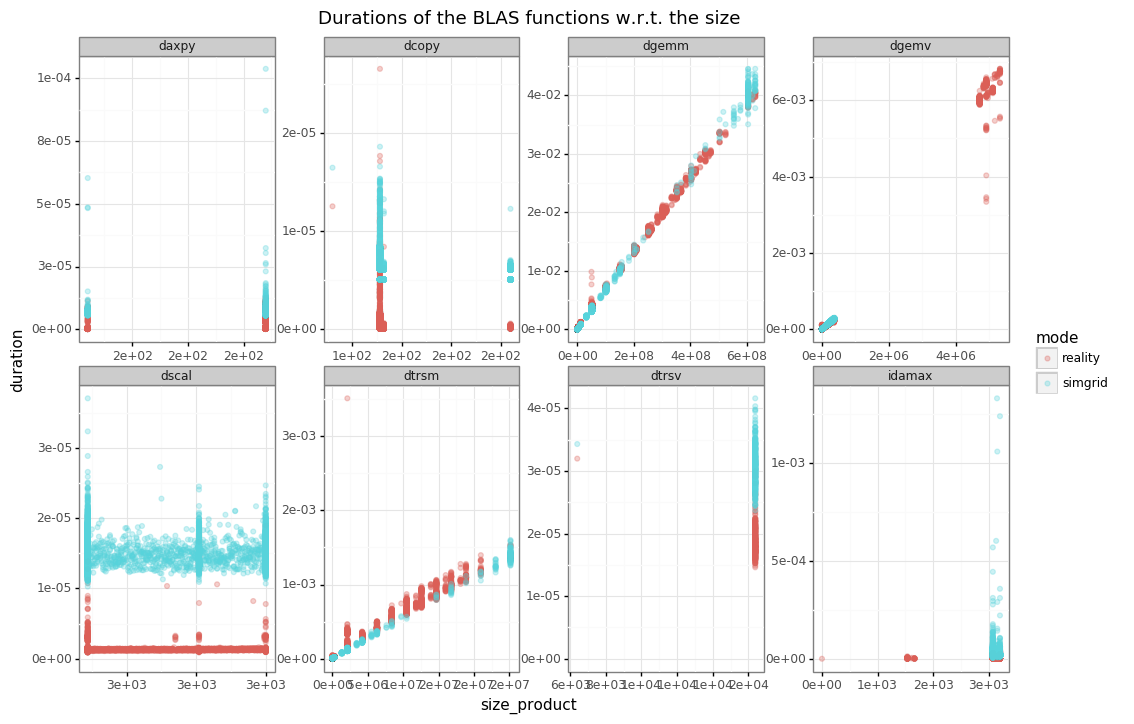

<ggplot: (-9223363306073300427)>

In [29]:
def plot_size(df):
    my_label = lambda l: ['%.0e' % x for x in l]
    plot = ggplot(df, aes(x='size_product', y='duration', color='mode')) + geom_point(alpha=0.3)
    plot = plot + facet_wrap('function', scales='free', nrow=2) + theme_bw() + ggtitle('Durations of the BLAS functions w.r.t. the size')
    plot = plot + theme(subplots_adjust={'hspace':0.15, 'wspace':0.25}) + expand_limits(y=0) # the subplots_adjust is to fix a display bug...
    return plot + scale_y_continuous(labels=my_label) + scale_x_continuous(labels=my_label)

plot_size(blas[~blas.function.str.startswith('HPL_')])

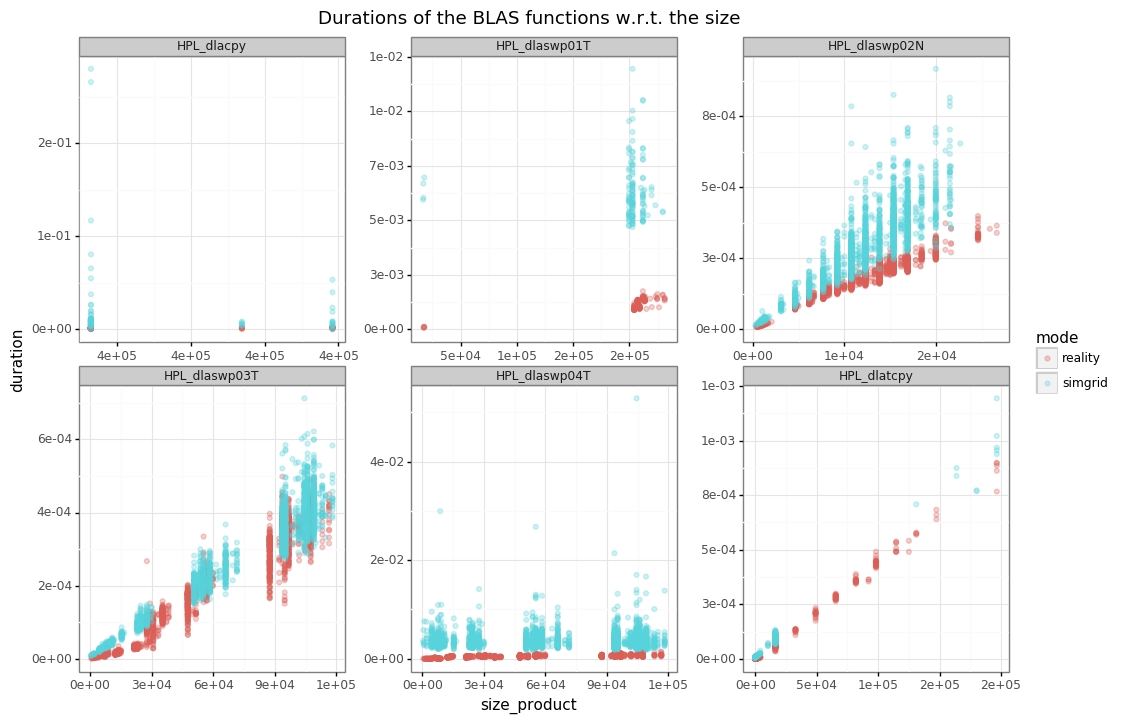

<ggplot: (8730774611506)>

In [30]:
plot_size(blas[blas.function.str.startswith('HPL_')])

## Computing the coefficients

In [31]:
blas['ratio'] = blas['size_product'] / blas['duration']

blas['large_size'] = False
for func in blas.function.unique():
    max_size = blas[blas['function'] == func]['size_product'].max()
    blas.loc[(blas['function'] == func) & (blas['size_product'] > max_size/3), 'large_size'] = True

In [32]:
ratios = blas[blas.large_size].groupby(['function', 'mode'])[['ratio']].agg(['mean', 'median', 'std'])
ratios.columns = ratios.columns.get_level_values(1)
ratios = ratios.reset_index()
ratios

,function,mode,mean,median,std
0,HPL_dlacpy,reality,4.068266e+08,3.889840e+08,1.909300e+08
1,HPL_dlacpy,simgrid,2.695761e+09,5.021351e+07,1.274358e+10
2,HPL_dlaswp01T,reality,1.781644e+08,1.619956e+08,2.964901e+07
3,HPL_dlaswp01T,simgrid,3.369916e+07,3.431784e+07,6.066766e+06
4,HPL_dlaswp02N,reality,6.808654e+07,6.818510e+07,6.148892e+06
5,HPL_dlaswp02N,simgrid,4.253476e+07,4.261616e+07,7.775423e+06
6,HPL_dlaswp03T,reality,2.915136e+08,2.768101e+08,5.094030e+07
7,HPL_dlaswp03T,simgrid,2.672090e+08,2.682526e+08,3.262190e+07
8,HPL_dlaswp04T,reality,1.306089e+08,1.283768e+08,3.842990e+07
9,HPL_dlaswp04T,simgrid,2.596101e+07,2.507625e+07,1.013906e+07


In [33]:
blas.groupby(['function', 'mode'])[['size_product']].agg(['mean', 'median', 'std'])

size_product                          
                               mean      median           std
function      mode                                           
HPL_dlacpy    reality  3.964160e+05    393216.0  6.217664e+03
              simgrid  3.964160e+05    393216.0  6.217664e+03
HPL_dlaswp01T reality  2.047914e+05    208896.0  3.374015e+04
              simgrid  1.997399e+05    202752.0  3.275577e+04
HPL_dlaswp02N reality  1.196755e+04     12288.0  4.411285e+03
              simgrid  1.229543e+04     12288.0  4.400395e+03
HPL_dlaswp03T reality  6.725198e+04     87552.0  3.339855e+04
              simgrid  7.132592e+04     93696.0  3.583470e+04
HPL_dlaswp04T reality  6.725198e+04     87552.0  3.339855e+04
              simgrid  7.132592e+04     93696.0  3.583470e+04
HPL_dlatcpy   reality  1.480176e+04     16384.0  2.030845e+04
              simgrid  1.250055e+04     16384.0  1.280810e+04
daxpy         reality  2.431373e+02       256.0  3.848666e+01
              simgrid  2.431373e+02       256.0  3.848666e+01
dcopy         reality  1.473191e+02       132.0  4.424442e+01
              simgrid  1.464414e+02       132.0  4.327941e+01
dgemm         reality  5.476596e+07  50331648.0  6.840360e+07
              simgrid  4.478167e+07  50331648.0  4.089497e+07
dgemv         reality  2.046660e+05     32768.0  7.980732e+05
              simgrid  7.076557e+04     32768.0  9.900190e+04
dscal         reality  3.100969e+03      3072.0  4.958180e+01
              simgrid  3.100969e+03      3072.0  4.958180e+01
dtrsm         reality  2.258270e+06   2097152.0  2.823876e+06
              simgrid  1.846569e+06   2097152.0  1.690037e+06
dtrsv         reality  1.635847e+04     16384.0  5.049126e+02
              simgrid  1.635847e+04     16384.0  5.049126e+02
idamax        reality  3.092934e+03      3072.0  1.240841e+02
              simgrid  3.101008e+03      3072.0  4.960766e+01